In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input/brent-oil-prices"))

['BrentOilPrices.csv']


# Input Data

In [2]:
df = pd.read_csv("../input/brent-oil-prices/BrentOilPrices.csv")

In [3]:
df.head()

,Date,Price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63


# Data Preprocessing

1) Need to convert Date column to standard format

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


# Data Exploration

**Visualizing Full Data as a line plot**

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Brent Oil Price Trend')

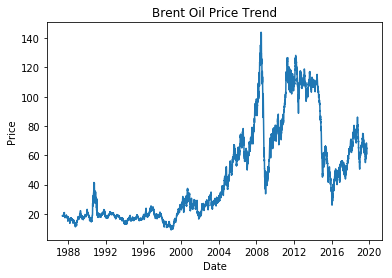

In [5]:
g = sns.lineplot(x='Date',y='Price',data = df)
plt.title("Brent Oil Price Trend")

**Function to plot Oil Price Trend between specific period**

In [6]:
def plot_price_trend(df, start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the line plot of the data using seaborn.
    
    The dataframe may not be indexed on any Datetime column.
    In this case, we use mask to filter out the date.
    
    PS - There is another function provided later in the notebook 
    which used indexed column to filter data
    """
    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    sdf = df.loc[mask]
    plt.figure(figsize = (10,5))
    chart = sns.lineplot(x='Date',y='Price',data = sdf)
#     chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("Brent Oil Price Trend")

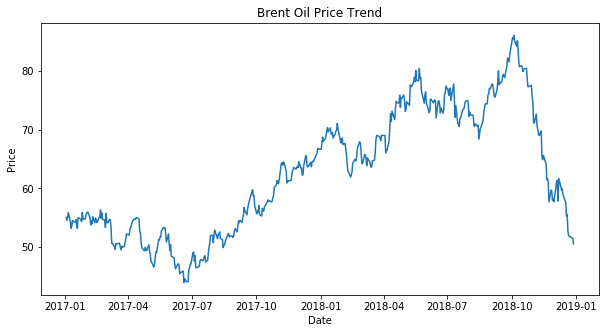

In [7]:
plot_price_trend(df,'2017-01-01','2019-01-01')

# Forecast Model

# 1) Using Prophet

Step 1) - First we import the Prophet class from fbprophet module and then create an instance of this.

In [8]:
from fbprophet import Prophet
m = Prophet()

Step 2) - Note that Prophet requires the date column as 'ds' and outcome varible as 'y'.
So we change this in our dataframe and check its data.

In [9]:
pro_df = df
pro_df.columns = ['ds','y']
pro_df.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Step 3) - Next we fit this dataframe into the model object created and then create a forecast for the Oil Price for the next 90 days. 

This might take ~1mins

In [10]:
m.fit(pro_df)
future = m.make_future_dataframe(periods = 90)
forecast = m.predict(future)

Step 4) - We check the forecast data has several components - trend, weakly and yearly seasonality - and for each of these components, we have the lower and upper confidence intervals data.

In [11]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,16.517478,2.014084,31.704059,16.517478,16.517478,1.005671,1.005671,1.005671,-0.439655,-0.439655,-0.439655,1.445326,1.445326,1.445326,0.0,0.0,0.0,17.523149
1,1987-05-21,16.520978,2.738078,33.474225,16.520978,16.520978,1.174547,1.174547,1.174547,-0.279999,-0.279999,-0.279999,1.454546,1.454546,1.454546,0.0,0.0,0.0,17.695525
2,1987-05-22,16.524478,2.584709,32.952096,16.524478,16.524478,1.089747,1.089747,1.089747,-0.372058,-0.372058,-0.372058,1.461805,1.461805,1.461805,0.0,0.0,0.0,17.614225
3,1987-05-25,16.534977,2.082697,32.685734,16.534977,16.534977,1.124346,1.124346,1.124346,-0.345335,-0.345335,-0.345335,1.469681,1.469681,1.469681,0.0,0.0,0.0,17.659322
4,1987-05-26,16.538476,1.385328,33.375611,16.538476,16.538476,1.009948,1.009948,1.009948,-0.457174,-0.457174,-0.457174,1.467121,1.467121,1.467121,0.0,0.0,0.0,17.548424


Step 5) - We plot these components of the forecast fit model.

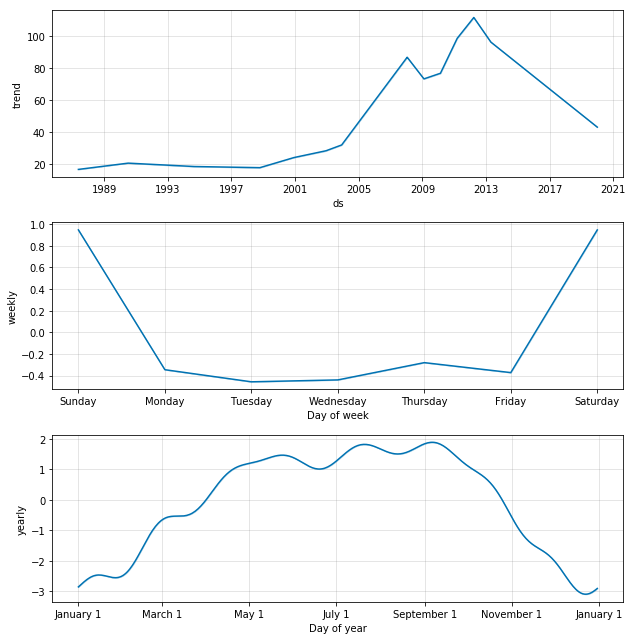

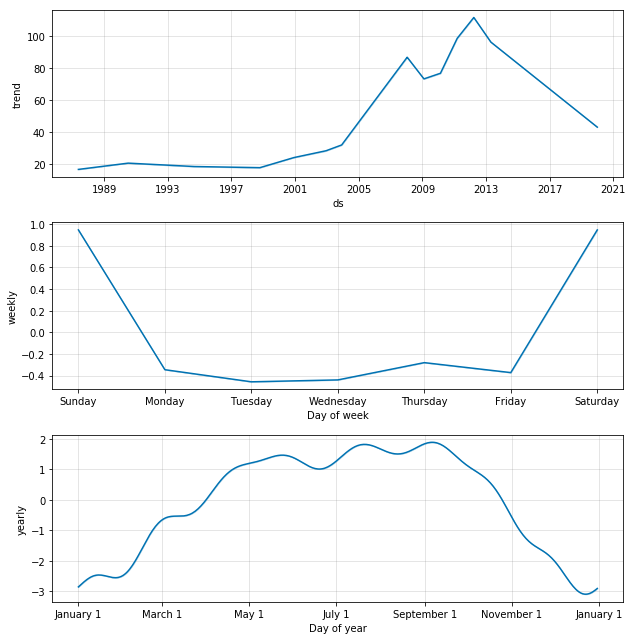

In [12]:
m.plot_components(forecast)

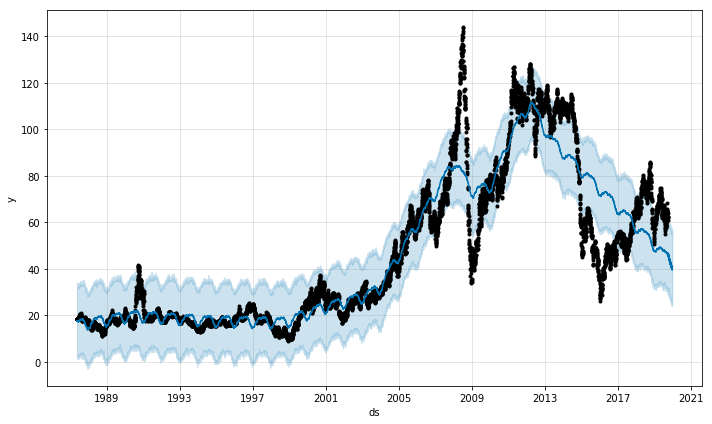

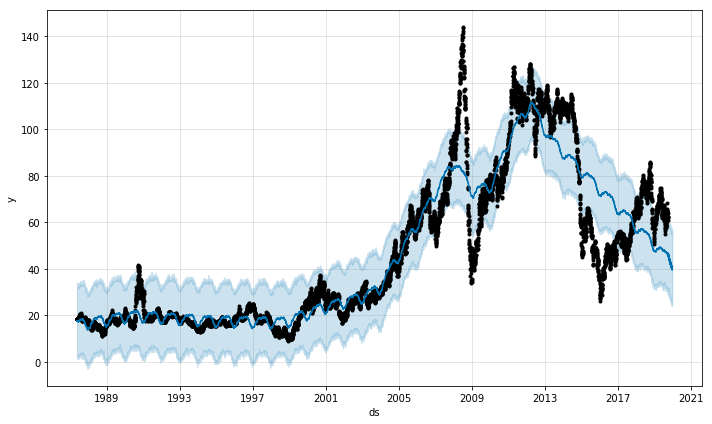

In [13]:
m.plot(forecast)

Step 6)- Next we want to visualize side by side the original data and the forecast data. So for this, we join the original and forecast data on the column 'ds'

In [14]:
cmp_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(pro_df.set_index('ds'))

In [15]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
1987-05-20,17.523149,2.014084,31.704059,18.63
1987-05-21,17.695525,2.738078,33.474225,18.45
1987-05-22,17.614225,2.584709,32.952096,18.55
1987-05-25,17.659322,2.082697,32.685734,18.60
1987-05-26,17.548424,1.385328,33.375611,18.63


In [16]:
cmp_df.tail(5)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-12-25,39.576682,24.133815,54.477783,NaN
2019-12-26,39.728494,24.256604,54.697344,NaN
2019-12-27,39.634463,24.003744,54.759384,NaN
2019-12-28,40.957000,25.442484,56.803192,NaN
2019-12-29,40.965097,25.674416,56.225206,NaN


Note that the original y data is NaN towards the end because, these are the predicted dates.

Step 7 - Then, we visualize the original and forecast data alongside each other

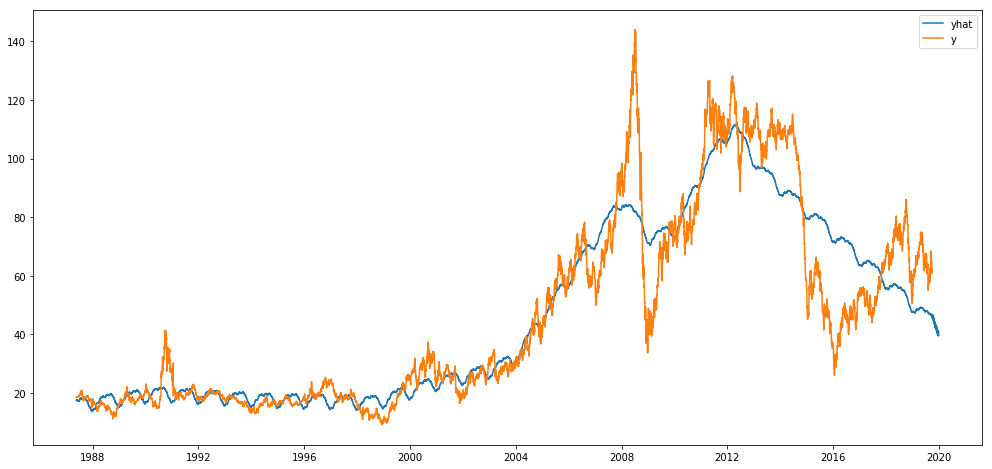

In [17]:
plt.figure(figsize=(17,8))
#plt.plot(cmp_df['yhat_lower'])
#plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['y'])
plt.legend()
plt.show()

Step 8) - From above graph, we are not able to readily see how many months data was forecast. 

So, We need a function which will show us the original and forecast data between a specified date range.

In [18]:
def plot_price_forecast(df,start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the actual and forecast data.
    
    Assumption: 
    - The dataframe has to be indexed on a Datetime column
    This makes the filtering very easy in pandas using df.loc
    """
    cmp_df = df.loc[start_date:end_date]
    plt.figure(figsize=(17,8))
    plt.plot(cmp_df['yhat'])
    plt.plot(cmp_df['y'])
    plt.legend()
    plt.show()

Stpe 9) - Using this function, we can see that, the original graph (orange) does not have data towards the end. This data can be taken from the forecasted graph (blue). 

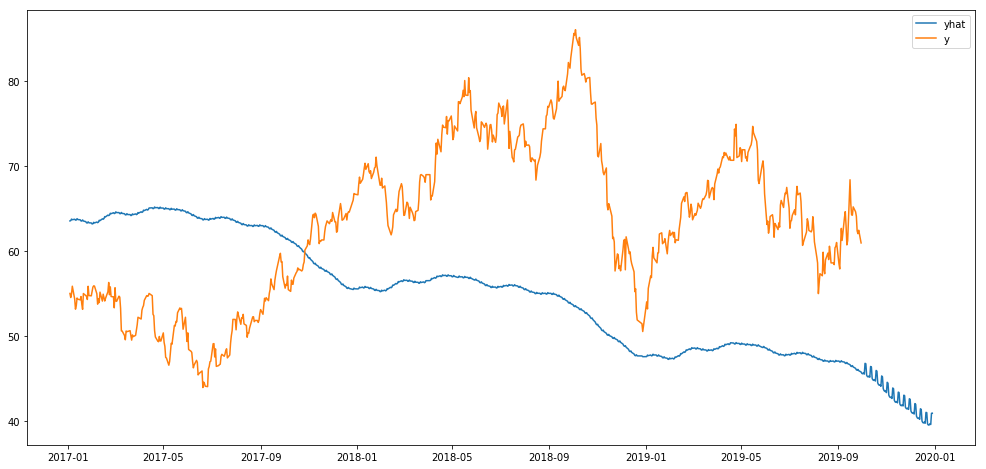

In [19]:
plot_price_forecast(cmp_df,'2017-01-01','2020-01-01')

# 2) Using ARIMA

Step 1) - First we import the required libraries

In [20]:
from statsmodels.tsa.arima_model import ARIMA    # ARIMA Modeling
from statsmodels.tsa.stattools import adfuller   # Augmented Dickey-Fuller Test for Checking Stationary
from statsmodels.tsa.stattools import acf, pacf  # Finding ARIMA parameters using Autocorrelation
from statsmodels.tsa.seasonal import seasonal_decompose # Decompose the ARIMA Forecast model

Step 2) - Arima requires the date column to be set as index

In [21]:
arima_df = df.set_index('ds')
arima_df.head()

,y
ds,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


Step 3) - Next we write a function that plots the Rolling mean and standard deviation and then checks the stationarity of the time series using Augmented Dickey - Fuller Test

Credit - https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima

In [22]:
# Perform Augmented Dickey–Fuller test to check if the given Time series is stationary:
def test_stationarity(ts):
    
    #Determing rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['y'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Step 4) - Next, we use this function to check if our given timeseries data is stationary or not

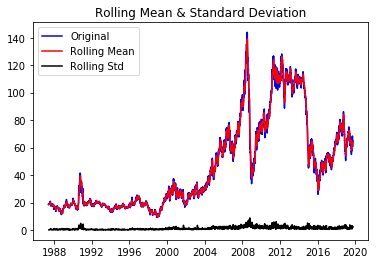

Results of Dickey-Fuller Test:
Test Statistic                   -1.954749
p-value                           0.306759
#Lags Used                       35.000000
Number of Observations Used    8180.000000
Critical Value (1%)              -3.431150
Critical Value (5%)              -2.861893
Critical Value (10%)             -2.566958
dtype: float64


In [23]:
test_stationarity(arima_df)

Observation - The null hypothesis of ADF test is the Time series is NOT stationary. We see that the Test Statistic (-1.95) is higher than 10% Critical Value (-2.56). This means this result is statistically significant at 90% confidence interval and so, we fail to reject the null hypothesis. 

This means that our time series data is NOT stationary.

Step 5) - Some definitions - 

Correlation - Describes how much two variables depend on each other. 

Partial Correlation - When multiple variables are involved, two variables may have direct relation as well as indirect relation (i.e x1 and x3 are related and x2 and x3 are related. Due to this indirect relation, x1 and x2 might be related). This is called partial correlation.

Auto Correlation - In a time series data, variable at a time step is dependent upon its lag values. This is called auto-correlation (i.e. variable depending upon its own values)

Partial Autocorrelation - describes correlation of a variable with its lag values after removing the effect of indirect correlation.



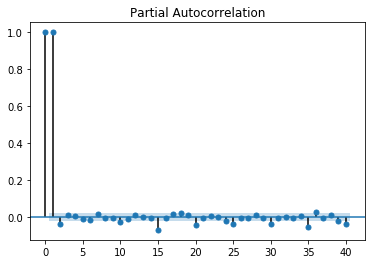

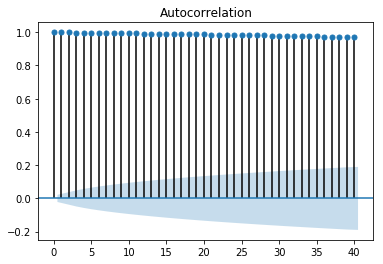

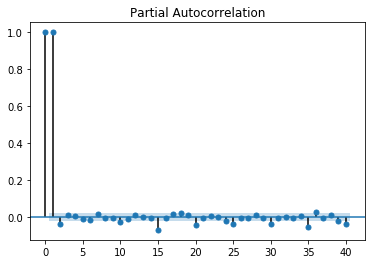

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(arima_df)
plot_pacf(arima_df)

In [25]:
# Implementing own function to create ACF plot
def get_acf_plot(ts):
    #calling acf function from stattools
    y = ts['y']
    lag_acf = acf(y, nlags=500)
    plt.figure(figsize=(16, 7))
    plt.plot(lag_acf, marker="o")
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')
    
def get_pacf_plot(ts):
    #calling pacf function from stattools
    y = arima_df['y']
    lag_pacf = pacf(y, nlags=50)
    plt.figure(figsize=(16, 7))
    plt.plot(lag_pacf, marker="o")
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



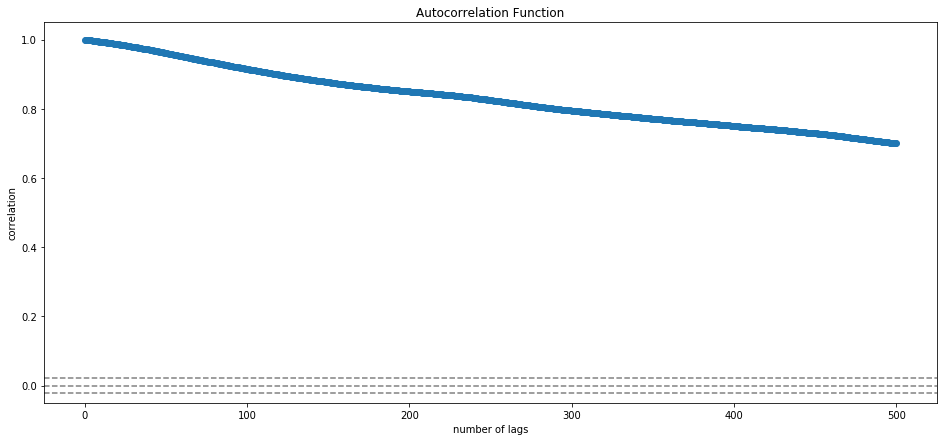

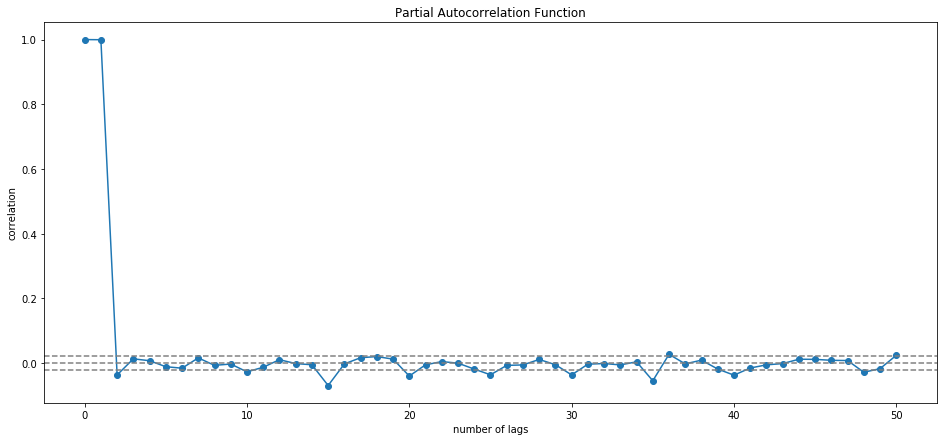

In [26]:
get_acf_plot(arima_df)
get_pacf_plot(arima_df)

Step 6) - Next we see some methods to make the data stationary

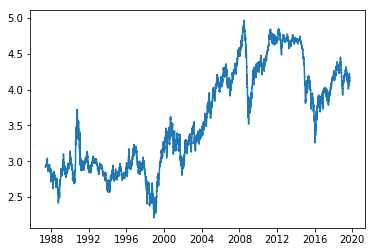

In [27]:
# Log Transformation
ts_log = np.log(arima_df)
plt.plot(ts_log)

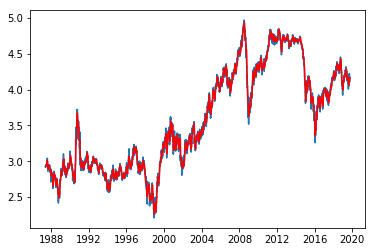

In [28]:
# Moving Average of last 12 values
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [29]:
# Differencing
ts_log_ma_diff = ts_log - moving_avg
ts_log_ma_diff.head(12)

,y
ds,
1987-05-20,NaN
1987-05-21,NaN
1987-05-22,NaN
1987-05-25,NaN
1987-05-26,NaN
1987-05-27,NaN
1987-05-28,NaN
1987-05-29,NaN
1987-06-01,NaN


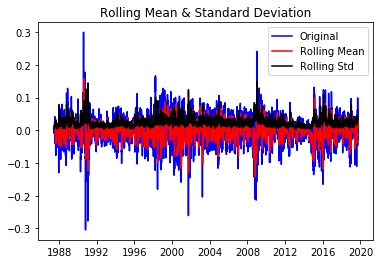

Results of Dickey-Fuller Test:
Test Statistic                -1.879553e+01
p-value                        2.023172e-30
#Lags Used                     1.500000e+01
Number of Observations Used    8.189000e+03
Critical Value (1%)           -3.431149e+00
Critical Value (5%)           -2.861893e+00
Critical Value (10%)          -2.566958e+00
dtype: float64


In [30]:
ts_log_ma_diff.dropna(inplace=True)
test_stationarity(ts_log_ma_diff)

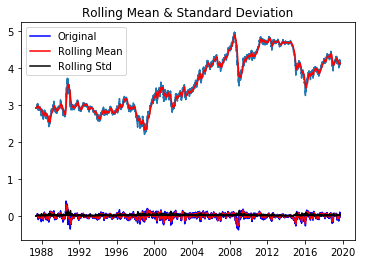

Results of Dickey-Fuller Test:
Test Statistic                -1.283031e+01
p-value                        5.892793e-24
#Lags Used                     1.500000e+01
Number of Observations Used    8.200000e+03
Critical Value (1%)           -3.431148e+00
Critical Value (5%)           -2.861893e+00
Critical Value (10%)          -2.566958e+00
dtype: float64


In [31]:
# Exponentially weighted moving average 
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Step 8) - ARIMA models

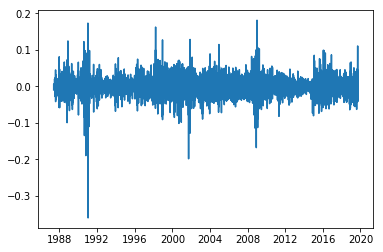

In [32]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

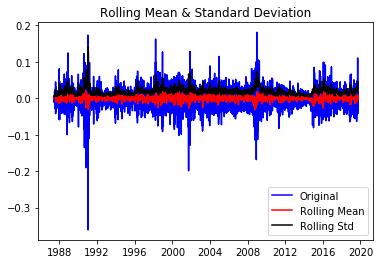

Results of Dickey-Fuller Test:
Test Statistic                  -21.500963
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    8200.000000
Critical Value (1%)              -3.431148
Critical Value (5%)              -2.861893
Critical Value (10%)             -2.566958
dtype: float64


In [33]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

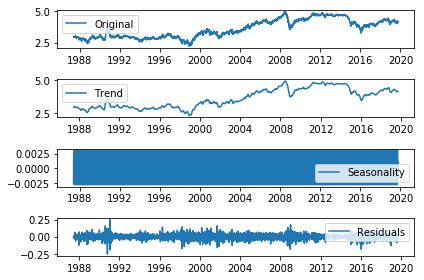

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

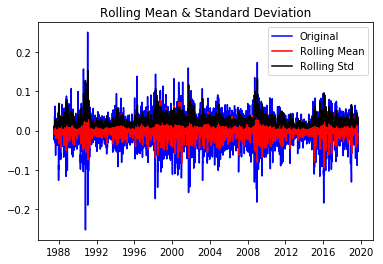

Results of Dickey-Fuller Test:
Test Statistic                  -21.162608
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8148.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64


In [35]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



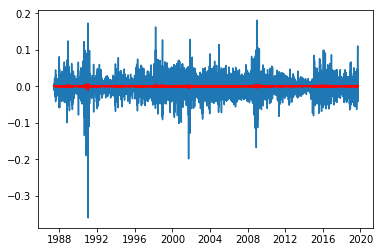

In [36]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

# 3) Using LSTM